## Système de Recommandation de Contenus avec SARSA

### 🧠 Objectif du projet :
Construire un système de recommandation intelligent qui apprend à proposer les contenus les plus pertinents aux utilisateurs en analysant leurs interactions (clics, temps passé, etc.) sur une plateforme en ligne. Le système utilise l’algorithme SARSA (State-Action-Reward-State-Action) de Reinforcement Learning pour apprendre une politique de recommandation optimisée.



#### Labraries

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


#### Load data

In [110]:
df = pd.read_csv("data/merged_movie_data.csv",sep=';')

In [111]:
df.sample(10)


,userId,movieId,rating,timestamp,title,genres
27002,182,6645,4.5,1063274161,THX 1138 (1971),Action|Adventure|Drama|Sci-Fi
67911,438,4446,3.5,1105654697,Final Fantasy: The Spirits Within (2001),Adventure|Animation|Fantasy|Sci-Fi
72913,469,3832,4.0,965336407,"Black Sabbath (Tre volti della paura, I) (1963)",Horror
70672,452,1036,4.0,1013394799,Die Hard (1988),Action|Crime|Thriller
87296,562,70336,3.5,1368896353,G.I. Joe: The Rise of Cobra (2009),Action|Adventure|Sci-Fi|Thriller
67622,438,318,5.0,1105649728,"Shawshank Redemption, The (1994)",Crime|Drama
100732,610,119145,4.5,1493846044,Kingsman: The Secret Service (2015),Action|Adventure|Comedy|Crime
69070,448,2641,3.0,1019125353,Superman II (1980),Action|Sci-Fi
58593,382,858,5.0,1515160584,"Godfather, The (1972)",Crime|Drama
20740,137,589,3.5,1204859360,Terminator 2: Judgment Day (1991),Action|Sci-Fi


#### Filtrage des top utilisateurs et films

**=> Des milliers d’utilisateurs et de films.** 

**=> Beaucoup de données manquantes (certains utilisateurs notent très peu de films).**

**=> Un grand déséquilibre (quelques films populaires sont notés très souvent, d’autres très rarement).**

In [112]:
top_users = df['userId'].value_counts().head(20).index.tolist()
top_movies = df['movieId'].value_counts().head(50).index.tolist()
df = df[df['userId'].isin(top_users) & df['movieId'].isin(top_movies)]

#### # Réindexation


**=> userId pour les lignes de Q-Table**

**=> movieId pour les lignes de Q-Table**

**=> idx_to_movie lorsqu'on extrait argmax(Q["state"]) pour traduire l’index en vrai movieId**

In [113]:
user_to_idx = {uid: idx for idx, uid in enumerate(sorted(df['userId'].unique()))}
movie_to_idx = {mid: idx for idx, mid in enumerate(sorted(df['movieId'].unique()))}
idx_to_movie = {idx: mid for mid, idx in movie_to_idx.items()}
idx_to_title = dict(zip(df['movieId'], df['title']))
movie_genres = dict(zip(df['movieId'], df['genres']))

In [114]:
n_users = len(user_to_idx)
n_movies = len(movie_to_idx)

#### Extraction de tous les genres possibles


In [115]:
genre_set = set()
for g in df['genres']:
    genre_set.update(g.split('|'))
all_genres = sorted(genre_set)
genre_to_idx = {g: i for i, g in enumerate(all_genres)}

#### Encodage des genres pour chaque film


In [116]:
def encoder_genres(genre_str):
    vector = np.zeros(len(all_genres))
    for g in genre_str.split('|'):
        if g in genre_to_idx:
            vector[genre_to_idx[g]] = 1
    return vector

In [117]:
movie_genre_vectors = {mid: encoder_genres(genre_str) for mid, genre_str in movie_genres.items()}


#### Q-table


In [118]:
q_table = np.zeros((n_users, n_movies))

# Hyperparamètres
alpha,gamma,epsilon,episodes ,max_steps,coeff_genre = 0.1, 0.9, 0.1,500, 10, 0.5


#### Politique ε-greedy


In [119]:
def choisir_action(user_idx):
    if np.random.rand() < epsilon:
        return np.random.randint(n_movies)
    else:    
        return np.argmax(q_table[user_idx])

#### Obtenir les genres préférés d’un utilisateur


In [120]:
def genres_utilisateur(user_id):
    liked = df[(df['userId'] == user_id) & (df['rating'] >= 3.0)]
    if liked.empty:
        return np.zeros(len(all_genres))
    vectors = np.array([movie_genre_vectors[mid] for mid in liked['movieId'] if mid in movie_genre_vectors])
    return vectors.mean(axis=0)

#### Récompense avec affinité de genre


In [121]:
def obtenir_recompense(user_idx, movie_idx):
    user_id = list(user_to_idx.keys())[user_idx]
    movie_id = list(movie_to_idx.keys())[movie_idx]

    note_row = df[(df['userId'] == user_id) & (df['movieId'] == movie_id)]
    note_reward = 1 if not note_row.empty and note_row['rating'].values[0] >= 3.0 else 0

    user_pref = genres_utilisateur(user_id)
    movie_vec = movie_genre_vectors.get(movie_id, np.zeros(len(all_genres)))
    genre_similarity = np.dot(user_pref, movie_vec) / (np.linalg.norm(user_pref) + 1e-5)

    return note_reward + coeff_genre * genre_similarity

#### Entraînement SARSA


In [132]:
clics_par_episode = []

for ep in tqdm(range(episodes), desc="Episodes"):
    user_idx = np.random.randint(n_users)
    action = choisir_action(user_idx)
    total_reward = 0

    for _ in range(max_steps):
        r = obtenir_recompense(user_idx, action)
        total_reward += r

        next_user_idx = np.random.randint(n_users)
        next_action = choisir_action(next_user_idx)

        cible = r + gamma * q_table[next_user_idx][next_action]
        q_table[user_idx][action] += alpha * (cible - q_table[user_idx][action])

        user_idx = next_user_idx
        action = next_action

    clics_par_episode.append(total_reward)



Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

Episodes: 100%|██████████| 500/500 [00:14<00:00, 34.75it/s]


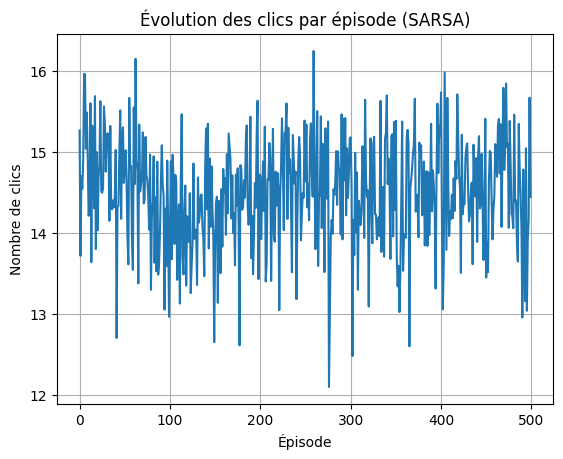

In [133]:
plt.plot(clics_par_episode)
plt.title("Évolution des clics par épisode (SARSA)")
plt.xlabel("Épisode")
plt.ylabel("Nombre de clics")
plt.grid()
plt.show()

In [134]:
print("\n🎯 Recommandation personnalisée pour chaque utilisateur :")
for user_id, user_idx in user_to_idx.items():
    best_movie_idx = np.argmax(q_table[user_idx])
    best_movie_id = idx_to_movie[best_movie_idx]
    titre = idx_to_title.get(best_movie_id, "Inconnu")
    print(f"Utilisateur {user_id} → 🎥 {titre}")


🎯 Recommandation personnalisée pour chaque utilisateur :
Utilisateur 68 → 🎥 Pirates of the Caribbean: The Curse of the Black Pearl (2003)
Utilisateur 177 → 🎥 Ace Ventura: Pet Detective (1994)
Utilisateur 182 → 🎥 Pulp Fiction (1994)
Utilisateur 232 → 🎥 Gladiator (2000)
Utilisateur 249 → 🎥 Lion King, The (1994)
Utilisateur 274 → 🎥 American Beauty (1999)
Utilisateur 288 → 🎥 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Utilisateur 298 → 🎥 Star Wars: Episode V - The Empire Strikes Back (1980)
Utilisateur 307 → 🎥 Shawshank Redemption, The (1994)
Utilisateur 318 → 🎥 Shawshank Redemption, The (1994)
Utilisateur 380 → 🎥 True Lies (1994)
Utilisateur 387 → 🎥 Godfather, The (1972)
Utilisateur 414 → 🎥 Terminator 2: Judgment Day (1991)
Utilisateur 448 → 🎥 Mrs. Doubtfire (1993)
Utilisateur 474 → 🎥 Lord of the Rings: The Two Towers, The (2002)
Utilisateur 480 → 🎥 Matrix, The (1999)
Utilisateur 599 → 🎥 Godfather, The (1972)
Utilisateur 603 → 🎥 Toy Story (1995)
Utilisa

In [135]:
# Générer les recommandations
recommandations = []

for user_id in user_to_idx:
    user_idx = user_to_idx[user_id]
    vus = set(df[df['userId'] == user_id]['movieId'])

    # Genres aimés (note >= 3.0)
    genres_aimes = []
    for _, row in df[(df['userId'] == user_id) & (df['rating'] >= 3.0)].iterrows():
        genres = movie_genres.get(row['movieId'], "")
        genres_aimes.extend(genres.split('|'))
    genres_aimes = set(genres_aimes)

    candidats = []
    for movie_idx in range(n_movies):
        movie_id = idx_to_movie[movie_idx]
        if movie_id in vus:
            continue
        genres_film = set(movie_genres.get(movie_id, "").split('|'))
        if not genres_aimes & genres_film:
            continue
        score = q_table[user_idx, movie_idx]
        candidats.append((movie_id, idx_to_title.get(movie_id, "Titre inconnu"), score))

    top_recos = sorted(candidats, key=lambda x: x[2], reverse=True)[:5]

    for reco in top_recos:
        recommandations.append({
            'userId': user_id,
            'movieId': reco[0],
            'title': reco[1],
            'score_Q': round(reco[2], 3)
        })

In [136]:
# Exporter les recommandations
df_reco = pd.DataFrame(recommandations)
df_reco.to_csv("recommandations_sarsa.csv", index=False)

print("✅ Recommandations générées dans recommandations_sarsa.csv")

✅ Recommandations générées dans recommandations_sarsa.csv


In [137]:
df_reco1 = pd.read_csv("recommandations_sarsa.csv")

In [139]:
df_reco1.sample(20)

,userId,movieId,title,score_Q
44,387,165,Die Hard: With a Vengeance (1995),0.000
24,298,150,Apollo 13 (1995),1.789
23,288,2858,American Beauty (1999),0.000
19,274,150,Apollo 13 (1995),0.960
47,448,318,"Shawshank Redemption, The (1994)",0.000
37,380,590,Dances with Wolves (1990),1.784
9,182,500,Mrs. Doubtfire (1993),0.000
48,448,364,"Lion King, The (1994)",0.000
1,177,590,Dances with Wolves (1990),1.826
34,318,367,"Mask, The (1994)",1.008
